<a href="https://colab.research.google.com/github/Thebestneminever/Deep-Learning-Projects/blob/main/image_to_image_translation_cycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# as mentioned in the paper, we apply random jittoring and mirroring of the 
# training data to avoid overfitting

# in random jittering , resize image from 256x256x3 to 286x286x3 and then randomly crop to get 
# target image of size 256x256x3

# in random mirroring, the image is randomly flipped horizontaly


In [ ]:
dataset, metadata = tfds.load('cycle_gan/summer2winter_yosemite',with_info=True,as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteKTHX65/cycle_gan-trainA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteKTHX65/cycle_gan-trainB.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteKTHX65/cycle_gan-testA.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0.incompleteKTHX65/cycle_gan-testB.tfrecord
Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/summer2winter_yosemite/2.0.0. Subsequent calls will reuse this data.


In [ ]:
train_summer, train_winter = dataset['trainA'], dataset['trainB']
test_summer, test_winter = dataset['testA'], dataset['testB']

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE  = 1
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [ ]:
def random_crop(image): # crop from 286 to 256
  cropped_image = tf.image.random_crop(value=image,size=[IMG_HEIGHT, IMG_WIDTH,3]) 
  return cropped_image

In [ ]:
def normalize(image): # normalize the pixel to [-1,1]
  image = tf.cast(image, tf.float32)
  image = (image/127.5)-1
  return image


In [ ]:
def random_jitter(image):
  # image --> 256
  
  # resize to 286
  image = tf.image.resize(image,size=[286,286],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) # 286

  # random crop
  image = random_crop(image) # 256

  # random mirror
  image = tf.image.random_flip_left_right(image) # 256
  return image

In [ ]:
def preprocess_image_train(image,label):
  # image --> 256

  image = random_jitter(image) # 256, to avoid overfitting to training set
  image = normalize(image) # pixel values are now in the range of  [-1,1]
  return image

In [ ]:
def preprocess_image_test(image,label):
  # image --> 256
  image = normalize(image) # pixel values are now in range of [-1,1]
  return image

In [ ]:
train_winter = train_winter.map(map_func=preprocess_image_train,num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_summer = train_summer.map(map_func=preprocess_image_train,num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
test_winter = test_winter.map(preprocess_image_test,AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_summer = test_summer.map(preprocess_image_test,AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_winter = next(iter(test_winter))
sample_summer = next(iter(test_summer))

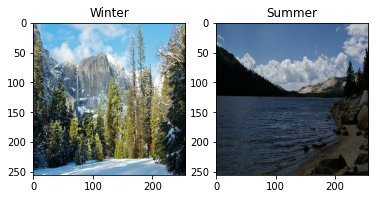

In [ ]:

plt.subplot(121)
plt.title("Winter")
plt.imshow(sample_winter[0]*0.5+0.5)
plt.subplot(122)
plt.title("Summer")
plt.imshow(sample_summer[0]*0.5+0.5)

In [ ]:
# cycle gan uses instance normalization instead of batch norm

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset


In [ ]:
def downsample(num_filters,kernel_size,apply_instancenorm=True):
  initializer = tf.random_normal_initializer(mean=0,stddev=0.02)

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(num_filters,kernel_size,strides=2,padding="same",kernel_initializer=initializer
                                    ,use_bias=False))
  if apply_instancenorm:
    result.add(InstanceNormalization())
  result.add(tf.keras.layers.LeakyReLU())
  return result


In [ ]:
def upsample(num_filters, kernel_size, apply_dropout=False):
  initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(num_filters,kernel_size,strides=2,padding="same",
                                             kernel_initializer=initializer,use_bias=False))
  result.add(InstanceNormalization())
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [ ]:
model =None

In [ ]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.input_ = tf.keras.layers.InputLayer(input_shape=(256,256,3)) # input layer 
    # input of shape 256,256,3
    self.down = [
    downsample(64,4,apply_instancenorm=False), # 128x128x64
    downsample(128,4,apply_instancenorm=True), # 64,64,128
    downsample(256,4,apply_instancenorm=True), # 32,32,256
    downsample(512,4,apply_instancenorm=True), # 16x16x512
    downsample(512,4,apply_instancenorm=True), # 8x8x512
    downsample(512,4,apply_instancenorm=True), # 4x4x512
    downsample(512,4,apply_instancenorm=True), # 2x2x512
    downsample(512,4,apply_instancenorm=True), # 1x1x512
    ]

    # input of shape 1x1x512
    self.up = [
    upsample(512,4,apply_dropout=False), # 2x2x 512 + 512 from skip connection
    upsample(512,4,apply_dropout=False), # 4x4x512+512 from skip connnection
    upsample(512,4,apply_dropout=False), # 8x8x512+512 from skip connnection
    upsample(512,4,apply_dropout=True), # 16x16x512 + 512 from skip connnection
    upsample(256,4,apply_dropout=True), # 32x32x256+256 from skip connnection
    upsample(128,4,apply_dropout=True), # 64x64x128+128 from skip connnection
    upsample(64,4,apply_dropout=True), # 128x128x64 + 64 from skip connnection 
    ]

    # input of shape 128x128x64+64
    self.last = tf.keras.layers.Conv2DTranspose(filters=3,kernel_size=4,strides=2,padding="same",
                                                kernel_initializer  = tf.random_normal_initializer(0.0,0.002),
                                                activation="tanh")
    # output shape of 256x256x3 with tanh activations so the pixels will be in the range of [-1,1]
    
    self.concat = tf.keras.layers.Concatenate(axis=-1) # to concatenate for skip connections

  def call(self,image):
    # the image is the image we wish to modify
    skips = [] # for skip connections
    x = self.input_(image)
    for down in self.down:
      x = down(x)
      skips.append(x)

    skips = reversed(skips[:-1])

    for up,skip in zip(self.up,skips):
      x = up(x)
      x = self.concat([x, skip])

    x = self.last(x)
    return x



In [ ]:
model = None

In [ ]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    # input --> generated 256,256,3

    self.layers_ = [
    tf.keras.layers.InputLayer(input_shape=(256,256,3)) # input layer
    ,downsample(64,4,apply_instancenorm=False) # 128,128,64
    ,downsample(128,4,apply_instancenorm=True) # 64,64,128
    , downsample(256,4,apply_instancenorm=True) # 32,32,256
    , tf.keras.layers.ZeroPadding2D()# 1+32+1,1+32+1,256
    , tf.keras.layers.Conv2D(filters=512,kernel_size=4,strides=1,padding="valid", # 31x31x512
                               kernel_initializer = tf.random_normal_initializer(0.0,0.002),use_bias=False)
    ,InstanceNormalization()
    ,tf.keras.layers.ZeroPadding2D() # 1+31+1,1+31+1,512
    ,tf.keras.layers.Conv2D(filters=1,kernel_size=4,strides=1,padding="valid", # 30x30x1
                               kernel_initializer = tf.random_normal_initializer(0.0,0.002),use_bias=False)
    ]
  def call(self,generated_image):
    # generated_image --> 256,256,3
    x = generated_image
    for layer in self.layers_:
      x = layer(x)
    
    return x
    # final output are 30x30x1 logits (of possibly any value)



In [ ]:
generator_w2s = Generator()
generator_s2w = Generator()
discriminator_s = Discriminator()
discriminator_w = Discriminator()

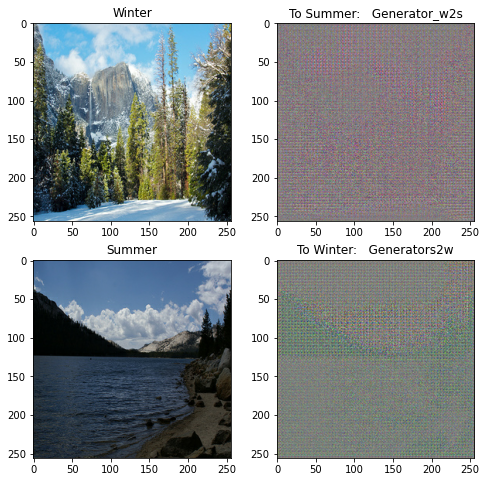

In [ ]:
to_summer = generator_w2s(sample_winter) 
to_winter = generator_s2w(sample_summer)
plt.figure(figsize=(8,8))
contrast = 8
title = ["Winter","To Summer:   Generator_w2s", "Summer","To Winter:   Generators2w"]
imgs = [sample_winter, to_summer, sample_summer,to_winter]

for i in range(len(title)):
  plt.subplot(2,2,i+1)
  plt.title(title[i])
  if i%2==0: # if real
    plt.imshow(imgs[i][0]*0.5+0.5)
  else: # if generated
    plt.imshow(imgs[i][0]*0.5*contrast + 0.5)
plt.show()

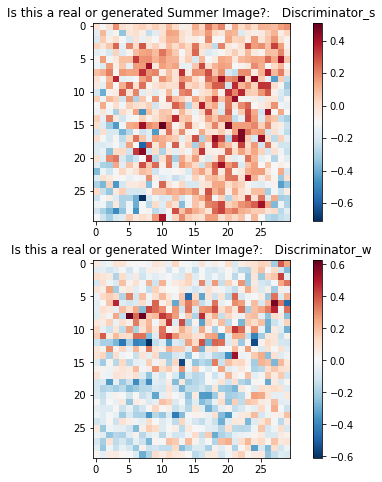

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.title("Is this a real or generated Summer Image?:   Discriminator_s")
plt.imshow(discriminator_s(to_summer)[0,:,:,0],cmap="RdBu_r")
plt.colorbar()

plt.subplot(212)
plt.title("Is this a real or generated Winter Image?:   Discriminator_w")
plt.imshow(discriminator_w(to_winter)[0,:,:,0],cmap="RdBu_r")
plt.colorbar()
plt.show()

In [ ]:
print("nemin")

nemin


In [ ]:
LAMBDA = 10

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(logits_real, logits_generated):
  #logits_real = 30x30x1
  #logits_fake = 30x30x1
  my_ones = tf.ones(logits_real.shape)
  loss_real = loss_object(my_ones,logits_real)

  my_zeros = tf.zeros(logits_generated.shape)
  loss_generated = loss_object(my_zeros,logits_generated)

  return loss_real + loss_generated

In [ ]:
def generator_loss(logits_generated):
  fooling_ones = tf.ones(logits_generated.shape)
  return loss_object(fooling_ones,logits_generated)

In [ ]:
print("Nemin")

Nemin


In [ ]:
def cycle_loss(input_image, cycled_image):
  # english1 --> french # en to fr translator
  # french --> english2 # fr to en translator
  # english1 == english2
  c_l = tf.reduce_mean(tf.abs(input_image-cycled_image))
  return LAMBDA*c_l

In [ ]:
def identity_loss(real_image,same_image): # Generator cant cheat by generating arbitary image
  # frech1 --> french2 # en to french translator
  # french1 == french2
  i_l = tf.reduce_mean(tf.abs(real_image-same_image))
  return 0.5*LAMBDA*i_l

In [ ]:
generator_s2w_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
generator_w2s_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

discriminator_w_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
discriminator_s_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_s2w=generator_s2w,
                           generator_w2s=generator_w2s,
                           discriminator_w=discriminator_w,
                           discriminator_s=discriminator_s,
                           generator_s2w_optimizer=generator_s2w_optimizer,
                           generator_w2s_optimizer=generator_w2s_optimizer,
                           discriminator_w_optimizer=discriminator_w_optimizer,
                           discriminator_s_optimizer=discriminator_s_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


In [ ]:
EPOCHS = 40

In [ ]:
def generate_image(generator, test_image):
  generated_image = generator(test_image,training=True)
  plt.figure(figsize=(12,12))
  images = [test_image[0],generated_image[0]]
  title = ["Input Image", "Generated Image"]
  plt.subplot(121)
  plt.title(title[0])
  plt.imshow(images[0]*0.5+0.5)
  plt.axis("off")

  plt.subplot(122)
  plt.title(title[1])
  plt.imshow(images[1]*0.5+0.5)
  plt.axis("off")

  plt.show()

In [ ]:
@tf.function
def train_step(train_summer,train_winter):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    
    # for disc loss, gen loss and cycle loss
    generated_winter = generator_s2w(train_summer,training=True) # generated winter from summer
    cycle_summer = generator_w2s(generated_winter,training=True) # summer back from generated winter
    
    generated_summer = generator_w2s(train_winter,training=True) # generated summer from winter
    cycle_winter = generator_s2w(generated_summer,training=True) # winter back from generated summer
    
    # for identity loss
    train_winter_tilde = generator_s2w(train_winter,training=True) 

    train_summer_tilde = generator_w2s(train_summer,training=True)

    # for disc loss/gen loss
    generated_winter_logits = discriminator_w(generated_winter,training=True)
    true_winter_logits = discriminator_w(train_winter,training=True)

    generated_summer_logits = discriminator_s(generated_summer,training=True)
    true_summer_logits = discriminator_s(train_summer,training=True)
    
    
    # losses

    # cycle loss
    cycle_loss_summer = cycle_loss(train_summer,cycle_summer)
    cycle_loss_winter = cycle_loss(train_winter, cycle_winter)
    tot_cycle_loss = cycle_loss_summer + cycle_loss_winter

    # identity loss
    identity_loss_w2s = identity_loss(train_summer,train_summer_tilde)
    identity_loss_s2w = identity_loss(train_winter,train_winter_tilde)


    # generator loss   =         generator gan loss              + total cycle loss + generator identity loss
    generator_w2s_loss = generator_loss(generated_summer_logits) + tot_cycle_loss + identity_loss_w2s
    generator_s2w_loss = generator_loss(generated_winter_logits) + tot_cycle_loss + identity_loss_s2w


    # discriminator gan loss
    disc_s_loss = discriminator_loss(true_summer_logits,generated_summer_logits)
    disc_w_loss = discriminator_loss(true_winter_logits,generated_winter_logits)

  # calculate gradients
  
  generator_w2s_trainable_params = generator_w2s.trainable_variables
  generator_w2s_gradients = tape.gradient(generator_w2s_loss,generator_w2s_trainable_params)

  generator_s2w_trainable_params = generator_s2w.trainable_variables
  generator_s2w_gradients = tape.gradient(generator_s2w_loss,generator_s2w_trainable_params)

  discriminator_s_trainable_params = discriminator_s.trainable_variables
  discriminator_s_gradients = tape.gradient(disc_s_loss,discriminator_s_trainable_params)

  discriminator_w_trainable_params = discriminator_w.trainable_variables
  discriminator_w_gradients = tape.gradient(disc_w_loss,discriminator_w_trainable_params)

 
  # apply gradients 
  generator_w2s_optimizer.apply_gradients(zip(  generator_w2s_gradients ,   generator_w2s_trainable_params))

  generator_s2w_optimizer.apply_gradients(zip(  generator_s2w_gradients ,   generator_s2w_trainable_params))

  discriminator_s_optimizer.apply_gradients(zip(discriminator_s_gradients,discriminator_s_trainable_params))

  discriminator_w_optimizer.apply_gradients(zip(discriminator_w_gradients,discriminator_w_trainable_params))




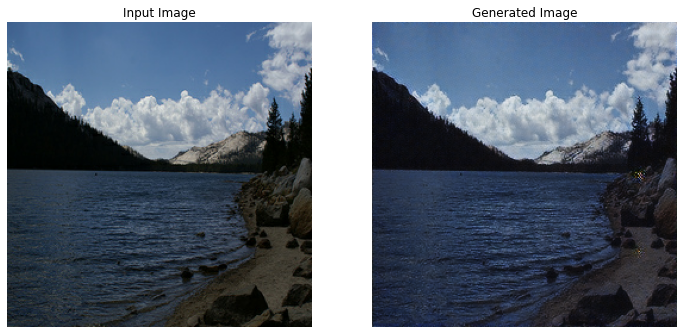

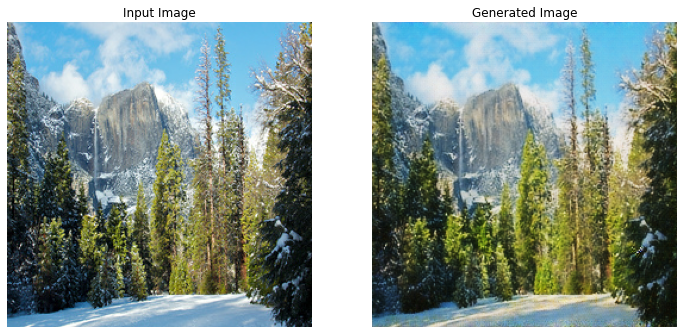

Epoch:  6
=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>=>

KeyboardInterrupt: ignored

In [ ]:
for epoch in range(EPOCHS):

  print(f"Epoch: {epoch: }")
  n = 0
  for image_summer, image_winter in tf.data.Dataset.zip((train_summer, train_winter)):
    train_step(image_summer, image_winter)
    if n % 10 == 0:
      print ('=>', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_summer) so that the progress of the model
  # is clearly visible.
  generate_image(generator_s2w, sample_summer)
  generate_image(generator_w2s, sample_winter)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()


